# Rainfall across the Australian wheatbelt

The Australian Bureau of Agricultural and Resource Economics and Sciences (ABARES)
defines a set of Australian broadacre zones and regions.

The last four very dry years across the "wheat-sheep" region
line up really well with the last four times Australia had to import grain
(1994-95, 2002-03, 2006-07, 2019-20; see
[ABC](https://www.abc.net.au/news/rural/2019-05-15/australia-approves-grain-imports/11113320),
[Guardian](https://www.theguardian.com/australia-news/2019/may/15/australia-to-import-wheat-for-first-time-in-12-years-as-drought-eats-into-grain-production)).

In [1]:
wheat_import_years = [1994, 2002, 2006, 2019]

In [2]:
import os
import sys
sys.path.append('/home/599/dbi599/unseen/unseen')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
import numpy as np
from dask.distributed import Client, LocalCluster
from IPython.display import Image
import cftime

import fileio
import time_utils

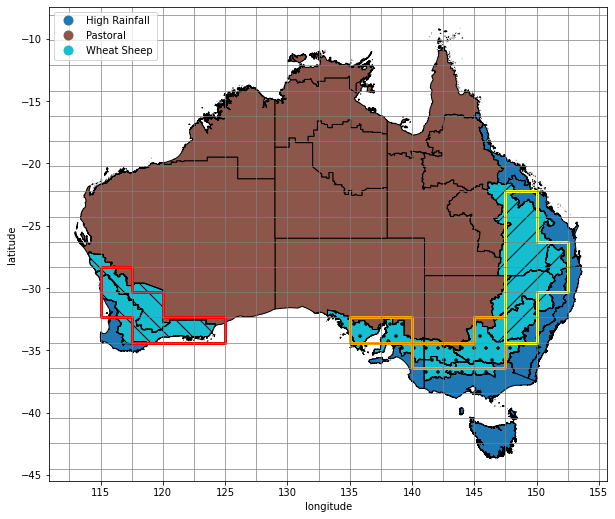

In [3]:
Image(filename='/g/data/xv83/dbi599/ag_regions.png')

In [4]:
# Optional parameters 
# (This cell is tagged "parameters")

In [5]:
# Parameters
agcd_file = (
    "/g/data/xv83/dbi599/ag/pr_agcd_1900-2019_A-DEC-mean_wheat-sheep-mean.zarr.zip"
)
cafe_file = "/g/data/xv83/dbi599/ag/pr_cafe-c5-d60-pX-f6_19811101-20201101_A-DEC-mean_wheat-sheep-mean.zarr.zip"
cafe_bc_file = "/g/data/xv83/dbi599/ag/pr_cafe-c5-d60-pX-f6_19900501-20191101_A-DEC-mean_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip"
fidelity_file = "/g/data/xv83/dbi599/ag/ks-test_pr_cafe-c5-d60-pX-f6_19900501-20191101_A-DEC-mean_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/ag/independence-test_pr_cafe-c5-d60-pX-f6_19900501-20191101_A-DEC-mean_wheat-sheep-south-west-mean_bias-corrected-agcd-additive.png"
region = "south-west"


In [6]:
# Required parameters
assert 'region' in locals(), "Must provide an AGCD data file (papermill option -p region [all south-west south-east or north-east])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(cafe_file), "Must provide an CAFE data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(cafe_bc_file), "Must provide an CAFE bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(fidelity_file), "Must provide an fidelity test file (papermill option -p fidelity_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [7]:
agcd_ds = fileio.open_file(agcd_file)

In [8]:
agcd_ds

<xarray.Dataset>
Dimensions:  (region: 4, time: 120)
Coordinates:
  * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
  * time     (time) object 1900-12-31 00:00:00 ... 2019-12-31 00:00:00
Data variables:
    pr       (time, region) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD v2.0.0 Snapshot (1900-01-01 to 2020-05-31)
    analysis_components:       total: the gridded accumulation of rainfall.
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The monthly rainfall data represents the amoun...
    time_coverage_end:         1900-12-31T00:00:00
    time_coverage_start:       1900-01-01T00:00:00
    title:                     Interpolated Rain Gauge Precipitation
    url:                       http://www.bom.gov.au/climate/
    uuid:                      43596dc1-c56e-42a2-ba87-4e3b726a6e60

In [9]:
agcd_ds['pr'] = agcd_ds['pr'] * 365
agcd_ds['pr'].attrs['units'] = 'mm yr-1'

In [10]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df[region] = agcd_ds['pr'].sel(region=region).values

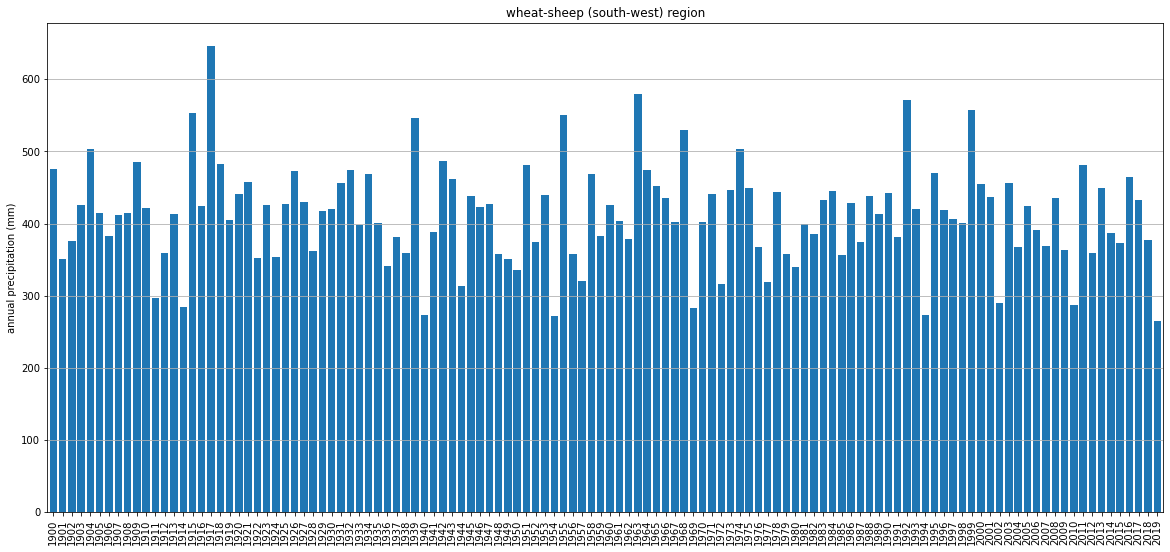

In [11]:
agcd_df[region].plot.bar(figsize=[20, 9], width=0.8)
plt.ylabel('annual precipitation (mm)')
plt.title(f'wheat-sheep ({region}) region')
plt.grid(axis='y')
plt.savefig(f'/g/data/xv83/dbi599/ag/wheat_sheep_precip_{region}.png', bbox_inches='tight', facecolor='white')
plt.show()

In [12]:
ranked_years = agcd_df[region].sort_values()
ranked_years.head(n=10)

2019    265.421957
1954    272.246127
1940    272.773507
1994    273.961593
1969    283.201668
1914    284.701028
2010    287.441779
2002    289.857193
1911    296.257544
1944    313.336638
Name: south-west, dtype: float64

In [13]:
def year_in_context(ranked_years_df, year):
    """Put a given year in context"""
    
    nyears = len(ranked_years_df)
    rank = ranked_years_df.index.get_loc(year) + 1
    percentile = (rank / nyears) * 100
    return_period = nyears / rank
    
    print(f'# {year} statistics:')
    print(f'{rank} in {nyears} year event')
    print(f'{percentile:.1f}% percentile')
    print(f'{return_period:.0f} year return period')
    print(' ')

In [14]:
for year in wheat_import_years:
    year_in_context(ranked_years, year)

# 1994 statistics:
4 in 120 year event
3.3% percentile
30 year return period
 
# 2002 statistics:
8 in 120 year event
6.7% percentile
15 year return period
 
# 2006 statistics:
46 in 120 year event
38.3% percentile
3 year return period
 
# 2019 statistics:
1 in 120 year event
0.8% percentile
120 year return period
 


## Model ensemble

In [15]:
cafe_ds = fileio.open_file(cafe_file)
cafe_bc_ds = fileio.open_file(cafe_bc_file)

In [16]:
cafe_bc_ds['pr'].attrs['units']

'mm d-1'

In [17]:
cafe_ds['pr'] = cafe_ds['pr'] * 365
cafe_ds['pr'].attrs['units'] = 'mm yr-1'

cafe_bc_ds['pr'] = cafe_bc_ds['pr'] * 365
cafe_bc_ds['pr'].attrs['units'] = 'mm yr-1'

### Bias correction and fidelity testing

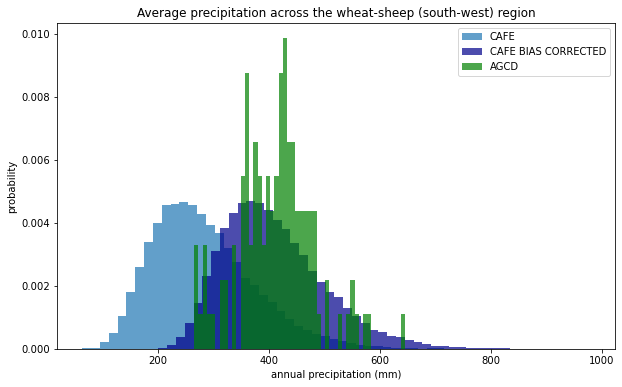

In [18]:
fig = plt.figure(figsize=[10, 6])
cafe_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE', alpha=0.7)
cafe_bc_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE BIAS CORRECTED', facecolor='darkblue', alpha=0.7)
agcd_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7)
plt.xlabel('annual precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Average precipitation across the wheat-sheep ({region}) region')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/wheat_sheep_precip_histogram_{region}.png', bbox_inches='tight', facecolor='white')
plt.show()

In [19]:
fidelity_ds = xr.open_zarr(fidelity_file)

In [20]:
fidelity_ds.sel(region=region)['pval'].values

array([0.15948194, 0.24724714, 0.28796504, 0.24873054, 0.17313396,
       0.16107372, 0.11934691, 0.10466001, 0.0970088 ])

These are the p-values for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

### Independence testing

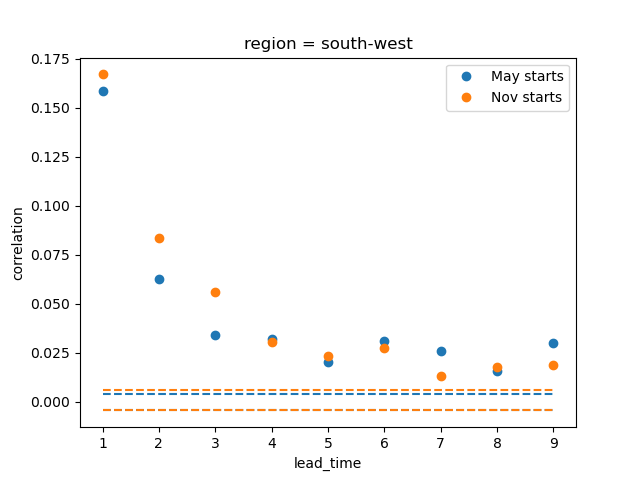

In [21]:
Image(filename=independence_plot)

### Exceedance curves

In [22]:
cafe_bc_ds_stacked = cafe_bc_ds.sel(region=region, lead_time=slice(3, None))['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
cafe_bc_ds_stacked.shape

(44928,)

In [24]:
cafe_bc_ds_stacked = time_utils.select_time_period(cafe_bc_ds_stacked, ['1990-01-01', '2019-12-31'])

In [25]:
cafe_bc_ds_stacked = cafe_bc_ds_stacked.dropna(dim='sample')

In [26]:
cafe_bc_ds_stacked.shape

(34272,)

In [27]:
def calc_exceedance(ds_stacked):
    """Calculate exceedance"""
    
    data = ds_stacked.compute()
    sorted_data = np.sort(data, axis=None)
    exceedance = 1.-np.arange(1.,len(data) + 1.)/len(data)
    
    return sorted_data, exceedance

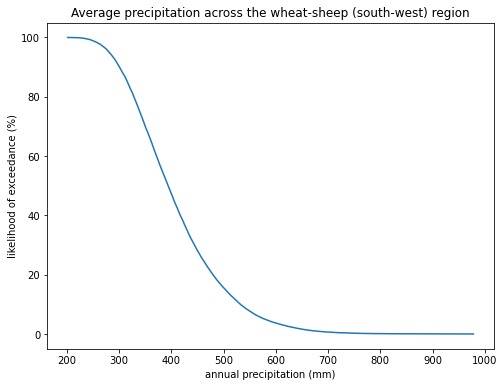

In [28]:
sorted_data, exceedance = calc_exceedance(cafe_bc_ds_stacked)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, exceedance * 100)
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of exceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
plt.show()

In [29]:
def event_in_context(data, threshold, year, direction):
    """Put an event in context
    
    Args:
      data (np.ndarray)
      threshold (float) : event threshold
      year (int) : year that the event occured in the observations
      direction (str) : 'less' or 'greater' than
    """

    n_population = len(data)
    if direction == 'less':
        n_events = np.sum(data < threshold)
    elif direction == 'greater':
        n_events = np.sum(data > threshold)
    else:
        raise ValueError("""direction must be 'less' or 'greater'""")
    percentile = (n_events / n_population) * 100
    return_period = 1 / (percentile / 100)
    
    print(f'# {year} ({threshold:.1f}mm) statistics:')
    print(f'{n_events} in {n_population} year event')
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period')
    print(' ')

#### Full 1990-2019 time period

# 1994 (274.0mm) statistics:
1276 in 34272 year event
3.72% percentile
27 year return period
 
# 2002 (289.9mm) statistics:
2412 in 34272 year event
7.04% percentile
14 year return period
 
# 2006 (391.8mm) statistics:
16847 in 34272 year event
49.16% percentile
2 year return period
 
# 2019 (265.4mm) statistics:
866 in 34272 year event
2.53% percentile
40 year return period
 


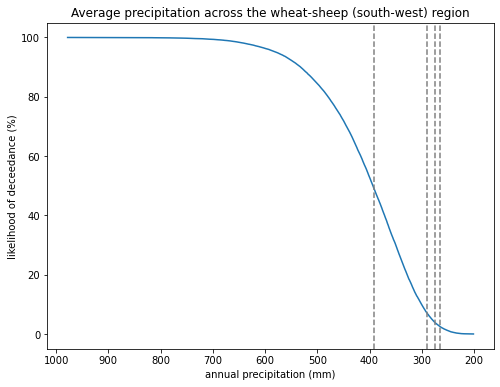

In [30]:
for year in wheat_import_years:
    event_in_context(sorted_data, ranked_years[year], year, 'less')

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, 100 - (exceedance * 100))
ax.invert_xaxis()
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')

for year in wheat_import_years:
    ax.axvline(ranked_years[year], color='0.5', linestyle='--')

plt.show()

#### By decade

1990-1999


# 1994 (274.0mm) statistics:
224 in 11232 year event
1.99% percentile
50 year return period
 


# 2002 (289.9mm) statistics:
455 in 11232 year event
4.05% percentile
25 year return period
 


# 2006 (391.8mm) statistics:
4549 in 11232 year event
40.50% percentile
2 year return period
 


# 2019 (265.4mm) statistics:
149 in 11232 year event
1.33% percentile
75 year return period
 


2000-2009


# 1994 (274.0mm) statistics:
556 in 11520 year event
4.83% percentile
21 year return period
 


# 2002 (289.9mm) statistics:
1056 in 11520 year event
9.17% percentile
11 year return period
 


# 2006 (391.8mm) statistics:
6456 in 11520 year event
56.04% percentile
2 year return period
 


# 2019 (265.4mm) statistics:
374 in 11520 year event
3.25% percentile
31 year return period
 


2010-2019


# 1994 (274.0mm) statistics:
496 in 11520 year event
4.31% percentile
23 year return period
 


# 2002 (289.9mm) statistics:
901 in 11520 year event
7.82% percentile
13 year return period
 


# 2006 (391.8mm) statistics:
5842 in 11520 year event
50.71% percentile
2 year return period
 


# 2019 (265.4mm) statistics:
343 in 11520 year event
2.98% percentile
34 year return period
 


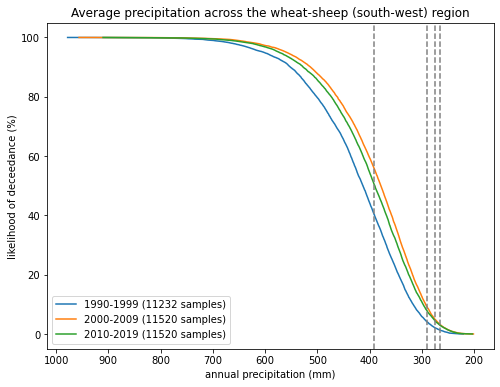

In [31]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()

for start_year in [1990, 2000, 2010]:
    end_year = start_year + 9
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    ds_selection = time_utils.select_time_period(cafe_bc_ds_stacked, [start_date, end_date])
    ds_selection = ds_selection.dropna('sample')
    sorted_data, exceedance = calc_exceedance(ds_selection)
    n_years = len(sorted_data)
    label = f'{start_year}-{end_year} ({n_years} samples)'
    ax.plot(sorted_data, 100 - (exceedance * 100), label=label)
    
    print(f'{start_year}-{end_year}')
    for year in wheat_import_years:
        event_in_context(ds_selection.values, ranked_years[year], year, 'less')

ax.invert_xaxis()
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
ax.legend()
for year in wheat_import_years:
    ax.axvline(ranked_years[year], color='0.5', linestyle='--')

plt.show()